# TCR simulations

We want to ultimately know how many cells to sequence in order to get a representative sample of TCR diversity.  To do that I will create a TCR simulator that we can use for sample size calculations.

The first step is generate the alpha and beta chains from the V, D and J (D is only for the beta chain) regions of the mouse C57BL6 genome.  We can then use this to randomly generate a number of T cells, remove X% based on positive and negative selection, and then calculate a number of different diversity measures.

These measures could include:

* V alpha and V beta pairing across all cells
* J alpha and J beta pairing across all cells
* Diversity in Va/b usage across all cells
* Diversity in Ja/b usage across all cells
* Total nucleotide diversity for all TCRa and TCRb sequences for each cell
* Nucleotide diversity across TCRa and b sequences for each cell
* CDR3 region length distribution across all cells
* N nucleotides added per cell
* Total nucleotide deviation from germline sequence per cell

## Ingredients

TCR V, D, J and constant region sequences for alpha and beta separately.

Biases in V and J usage for alpha and beta chains separately.


__NB__: The mRNA itself also needs to be in frame to be able to be translated - that might also have an impact on which V and J regions and combinations appear to be used.

In [1]:
import numpy as np
import pandas as pd
import re
import sys
sys.path.append("/Users/morgan02/src/Genomics/")
from Classes import Fasta
import random
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as stats

%matplotlib inline

In [2]:
def translate_sequence(sequence, frame):
    '''
    Translate a sequence using a specific frame    
    '''
    
    codon_table = {'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L', 'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
                   'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M', 'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
                   'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S', 'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
                   'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T', 'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
                   'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*', 'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
                   'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K', 'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
                   'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W', 'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
                   'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R', 'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'}
    
    aa_seq = ''
    
    for x in range(frame-1, len(sequence)):
        codon = sequence[x:x+3]
        if len(codon) == 3:
            aa_seq += codon_table[codon]

    return(aa_seq)


def find_stop(sequence, frame):
    '''
    Find the longest sequence before a stop codon in a particular frame
    '''
    
    codon_table = {'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L', 'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
                   'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M', 'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
                   'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S', 'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
                   'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T', 'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
                   'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*', 'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
                   'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K', 'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
                   'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W', 'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
                   'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R', 'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'}
    
    n_aa = 0
    for x in range(frame-1, len(sequence)):
        codon = sequence[x:x+3].upper()
        if len(codon) == 3:
            aa = codon_table[codon]
        if aa == "*":
            return(n_aa)
        else:
            n_aa += 1
            
    return(n_aa)
    

def get_ORF(sequence):
    '''
    Given a nucleotide sequence, scan for an ORF in the mRNA and return the expected 
    length of the amino acid sequence
    '''
    
    codon_table = {'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L', 'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
                   'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M', 'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
                   'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S', 'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
                   'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T', 'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
                   'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*', 'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
                   'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K', 'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
                   'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W', 'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
                   'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R', 'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'}
    
    # find the first MET
    up_seq = sequence.upper()
    aa_seq = ''
    
    # run 3 reading frames
    frame1 = ''
    frame2 = ''
    frame3 = ''
    start1 = None
    start2 = None
    start3 = None

    for x in range(0, len(up_seq), 3):
        codon1 = up_seq[x:x+3]
        codon2 = up_seq[x+1:x+4]
        codon3 = up_seq[x+2:x+5]
        
        if len(codon1) == 3:
            aa1 = codon_table[codon1]
            if aa1 == "M" and len(frame1) == 0:
                frame1 += aa1
                start1 = x
            elif aa1 != "M" and len(frame1) > 0:
                frame1 += aa1               
            else:
                pass
            
        if len(codon2) == 3:
            aa2 = codon_table[codon2]
            if aa2 == "M" and len(frame2) == 0:
                frame2 += aa2
                start2 = x
            elif aa2 != "M" and len(frame2) > 0:
                frame2 += aa2               
            else:
                pass
        
        if len(codon3) == 3:
            aa3 = codon_table[codon3]
            if aa3 == "M" and len(frame3) == 0:
                frame3 += aa3
                start3 = x
            elif aa3 != "M" and len(frame3) > 0:
                frame3 += aa3              
            else:
                pass

    # choop each frame at the first stop codon
    frame1 = "".join(frame1.split("*")[0])
    frame2 = "".join(frame2.split("*")[0])
    frame3 = "".join(frame3.split("*")[0])
    
    # pick the longest reading frame
    frames = [frame1, frame2, frame3]
    len_frames = [len(frame1), len(frame2), len(frame3)] 
    long_idx = max(range(len(len_frames)), key=len_frames.__getitem__)
    
    return(frames[long_idx], [1, 2, 3][long_idx], [start1, start2, start3][long_idx])
    
    

In [3]:
def get_TRAV(FASTA_DIR):

    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    trav_fasta = "/".join([FASTA_DIR, "TRAV.fasta"])
    tra_v = Fasta.Fasta(trav_fasta)

    tra_v_dict = {}

    tra_v_set = set()
    tra_count = 0
    for _fas in tra_v:
        # parse the header
        # select BL6
        parse_head = _fas.header.split("|")
        tra_gene = parse_head[1].split("*")[0]
        tra_pos = parse_head[5]

        if tra_gene not in tra_v_set:
            tra_v_set.add(tra_gene)
            tra_v_dict[tra_gene] = {"Sequence":_fas.sequence,
                                    "Gene":tra_gene,
                                    "Length":_fas.length}
            tra_count += 1

    return(tra_v_dict)

In [4]:
def get_TRAJ(FASTA_DIR):
    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    traj_fasta = "/".join([FASTA_DIR, "TRAJ.fasta"])
    tra_j = Fasta.Fasta(traj_fasta)

    tra_j_dict = {}

    tra_j_set = set()
    tra_count = 0
    for _fas in tra_j:
        # parse the header
        # select BL6
        parse_head = _fas.header.split("|")
        tra_gene = parse_head[1].split("*")[0]
        tra_pos = parse_head[5]

        if tra_gene not in tra_j_set:
            tra_j_set.add(tra_gene)
            tra_j_dict[tra_gene] = {"Sequence":_fas.sequence,
                                    "Gene":tra_gene,
                                    "Length":_fas.length}
            tra_count += 1

    return(tra_j_dict)


def get_TRAC(FASTA_DIR):
    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    trac_fasta = "/".join([FASTA_DIR, "TRAC.fasta"]) 
    tra_c = Fasta.Fasta(trac_fasta)

    tra_c_dict = {}

    tra_c_set = set()
    tra_count = 0
    for _fas in tra_c:
        # parse the header
        # select BL6
        parse_head = _fas.header.split("|")
        tra_gene = parse_head[1].split("*")[0]
        tra_pos = parse_head[5]

        if tra_gene not in tra_c_set:
            tra_c_set.add(tra_gene)
            tra_c_dict[tra_gene] = {"Sequence":_fas.sequence,
                                    "Gene":tra_gene,
                                    "Length":_fas.length}
            tra_count += 1
    return(tra_c_dict)

In [5]:
def get_TRBV(FASTA_DIR):
    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    trbv_fasta = "/".join([FASTA_DIR, "TRBV.fasta"])
    trb_v = Fasta.Fasta(trbv_fasta)

    trb_v_dict = {}

    trb_v_set = set()
    trb_count = 0
    for _fas in trb_v:
        # parse the header
        # select BL6
        parse_head = _fas.header.split("|")
        trb_gene = parse_head[1].split("*")[0]
        trb_pos = parse_head[5]

        if trb_gene not in trb_v_set:
            trb_v_set.add(trb_gene)
            trb_v_dict[trb_gene] = {"Sequence":_fas.sequence,
                                    "Gene":trb_gene,
                                    "Length":_fas.length}
            trb_count += 1
    
    return(trb_v_dict)

In [6]:
def get_TRBJ1(FASTA_DIR):
    # this needs to be split into the J1 and J2 regions
    
    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    trbj_fasta = "/".join([FASTA_DIR, "TRBJ1.fasta"]) 
    trb_j = Fasta.Fasta(trbj_fasta)

    trb_j_dict = {}

    trb_j_set = set()
    trb_count = 0
    for _fas in trb_j:
        # parse the header
        # select BL6
        parse_head = _fas.header.split("|")
        trb_gene = parse_head[1].split("*")[0]
        trb_pos = parse_head[5]

        if trb_gene not in trb_j_set:
            trb_j_set.add(trb_gene)
            trb_j_dict[trb_gene] = {"Sequence":_fas.sequence,
                                    "Gene":trb_gene,
                                    "Length":_fas.length}
            trb_count += 1
    
    return(trb_j_dict)

def get_TRBJ2(FASTA_DIR):
    # this needs to be split into the J1 and J2 regions
    
    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    trbj_fasta = "/".join([FASTA_DIR, "TRBJ2.fasta"]) 
    trb_j = Fasta.Fasta(trbj_fasta)

    trb_j_dict = {}

    trb_j_set = set()
    trb_count = 0
    for _fas in trb_j:
        # parse the header
        # select BL6
        parse_head = _fas.header.split("|")
        trb_gene = parse_head[1].split("*")[0]
        trb_pos = parse_head[5]

        if trb_gene not in trb_j_set:
            trb_j_set.add(trb_gene)
            trb_j_dict[trb_gene] = {"Sequence":_fas.sequence,
                                    "Gene":trb_gene,
                                    "Length":_fas.length}
            trb_count += 1
    
    return(trb_j_dict)

In [7]:
def get_TRBD(FASTA_DIR):
    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    trbd_fasta = "/".join([FASTA_DIR, "TRBD.fasta"]) 
    trb_d = Fasta.Fasta(trbd_fasta)

    trb_d_dict = {}

    trb_d_set = set()
    trb_count = 0
    for _fas in trb_d:
        # parse the header
        parse_head = _fas.header.split("|")        
        trb_gene = parse_head[1].split("*")[0]
        trb_pos = parse_head[5]

        if trb_gene not in trb_d_set:
            trb_d_set.add(trb_gene)
            trb_d_dict[trb_gene] = {"Sequence":_fas.sequence,
                                    "Gene":trb_gene,
                                    "Length":_fas.length}
            trb_count += 1

    return(trb_d_dict)


def get_TRBC(FASTA_DIR):
    # get the sequence representation for each TRA and TRB gene segment
    # I'll just select the first allele for each sequence first
    trbc_fasta = "/".join([FASTA_DIR, "TRBC.fasta"]) 
    trb_c = Fasta.Fasta(trbc_fasta)

    trb_c_dict = {}

    trb_c_set = set()
    trb_count = 0
    for _fas in trb_c:
        # parse the header
        # select BL6
        parse_head = _fas.header.split("|")
        trb_gene = parse_head[1].split("*")[0]
        trb_pos = parse_head[5]

        if trb_gene not in trb_c_set:
            trb_c_set.add(trb_gene)
            trb_c_dict[trb_gene] = {"Sequence":_fas.sequence,
                                    "Gene":trb_gene,
                                    "Length":_fas.length}
            trb_count += 1
    return(trb_c_dict)

In [88]:
def get_CDR(aa_sequence, region=1):
    '''
    Retrieve the CDR regions, either 1, 2, or 3, from the amino acid sequence.  
    These use the IMGT definitions as these are where the sequences are derived 
    from ultimately.
    
    CDR1 definition: Pos 27-38
    
    CDR2 definition: Pos 56-65
    
    CDR3 definition: Pos 105-117 (J-PHE/J-TRP @ pos118)
    '''
    
    # CDRs are in the V-region mostly, the CDR3 overlaps in to the J region
    if region == 1:
        cdr = aa_sequence[26:38]
    elif region == 2:
        cdr = aa_sequence[55:65]
    elif region == 3:
        # find the first C around 104 and the F or W after 117
        cdr3_cys = re.search("C", aa_sequence[100:135])
        cdr3_phe = re.search("FG.G", aa_sequence[100:180])
        
        if cdr3_cys and cdr3_phe:
            cdr3_start = 100 + cdr3_cys.end()
            cdr3_end = 100 + cdr3_phe.end()
            cdr = aa_sequence[cdr3_start:cdr3_end]
            
        elif cdr3_cys and not cdr3_phe:
            cdr3_start = 100 + cdr3_cys.end()
            cdr3_phe = re.search("FG.G", aa_sequence[cdr3_start:cdr3_start+50])
            try:
                cdr3_end = cdr3_start + cdr3_phe.end()
            except AttributeError:
                cdr3_end = None
            
            cdr = aa_sequence[cdr3_start:cdr3_end]
            
        elif cdr3_phe and not cdr3_cys:
            cdr3_end = 100 + cdr3_phe.end()
            cdr3_cys = re.search("C", aa_sequence[cdr3_end-50:cdr3_end])
            try:
                cdr3_start = cdr3_end - 50 + cdr3_cys.end()
            except AttributeError:
                cdr3_start = 104
            cdr = aa_sequence[cdr3_start:cdr3_end]
        
        # do a final check.  If the CDR > 50 AA then something has gone wrong
        cdr = aa_sequence[cdr3_start:cdr3_end]
        if len(cdr) > 50:
            cdr = ""
        else:
            pass
    
    return(cdr)

In [89]:
def make_TCRA(fasta_dir, tra_v_dict, tra_j_dict):
    '''
    Make a TCR beta chain, record which V, D and J regions were used
    '''

    keep_chain = True
    # now simulate a cell and randomly select the appropriate genes
    # select a trV then a trJ region (also include the TRD region for the beta chain)
    tra_v_select = random.choice(list(tra_v_dict.keys()))
    tra_j_select = random.choice(list(tra_j_dict.keys()))
    
    tra_c_dict = get_TRAC(fasta_dir)
    tra_c_select = list(tra_c_dict.keys())[0]

    # concatenate together and remove gaps
    # add 1-4 random nucleotides between V and J region
    # assume a Poisson sampling with lambda=4
    rand_N = np.random.poisson(4)
    N_nucs = "".join([random.sample(['a', 'c', 't', 'g'], 1)[0] for x in range(rand_N)])
    
    tra_chain = "".join([tra_v_dict[tra_v_select]['Sequence'], N_nucs,
                         tra_j_dict[tra_j_select]['Sequence'], tra_c_dict[tra_c_select]['Sequence']])
    tra_chain = tra_chain.replace('.', '')
    
    # given a particular ORF, does it contain the constant region?
    tra_aa, tra_frame, tra_start = get_ORF(tra_chain)
    
    # AA sequence must include constant region as well
    # calculate expected length based on full open reading frame
    # the expected end point would be the longest run in the constant
    # region before the first stop codon
    tra_orf = tra_chain[tra_start:tra_start+len(tra_aa)*3]
    tra_stop = tra_start + (len(tra_aa) * 3) + 3

    # if there is no start codon in the V region, then this is a rejected event
    v_orf = get_ORF(tra_v_dict[tra_v_select]['Sequence'].replace('.', ''))
    
    if len(v_orf) < 1:
        keep_chain = False
        
    # if there is no (D)J region included then this is also a rejected event  
    v_seq = tra_v_dict[tra_v_select]['Sequence'].replace('.', '')
    v_len = len(v_seq[tra_start: ])
       
    j_seq = tra_j_dict[tra_j_select]['Sequence'].replace('.', '')
    j_len = len("".join([v_seq, N_nucs, j_seq])[tra_start + v_len:])
    
    c_seq = tra_c_dict[tra_c_select]['Sequence'].replace('.', '')
    c_len = len("".join([v_seq, N_nucs, j_seq, c_seq])[tra_start + v_len + j_len:])
    
    if v_len == 0:
        keep_chain = False
    elif v_len > tra_stop:
        keep_chain = False
                
    if j_len == 0:
        keep_chain = False
    elif v_len + j_len > tra_stop:
        keep_chain = False        
        
    # the TCR alpha constant chain final exon is untranslated (514 nt) + 109
    if c_len == 0:
        keep_chain = False
    elif len(tra_orf) < len(tra_chain[:len(tra_chain)-(514 + 108)]):
        keep_chain = False        

    tcr_a_dict = {"V": tra_v_select,
                  "J": tra_j_select,
                  "C": tra_c_select,
                  "RNA": tra_chain,
                  "Frame": tra_frame,
                  "AA": tra_aa,
                  "Valid.Chain": keep_chain}
    
    return(tcr_a_dict)

def make_TCRB(fasta_dir, trb_v_dict, trb_j_dict, trb_d_dict, attempt=1):
    '''
    Make a TCR beta chain, record which V, D and J regions were used
    
    TCR beta will try to use D1, C1 and J1 regions first, if this fails then 
    it will switch to using D2, C2 and J2 regions.
    '''
    
    keep_chain = True
    if attempt == 1:
        trb_d_select = 'TRBD1'
    else:
        trb_d_select = 'TRBD2'
        
    trb_v_select = random.choice(list(trb_v_dict.keys()))
    
    trb_j_select = random.choice(list(trb_j_dict.keys()))
    
    trb_c_dict = get_TRBC(fasta_dir)
    
    # if D1 then select C1, else C2
    if trb_d_select in ['TRBD1']:
        trb_c_select = 'TRBC1'
    else:
        trb_c_select = 'TRBC2'
    
    # concatenate together and remove gaps
    # add 1-4 random nucleotides between V and J region
    # assume a Poisson sampling with lambda=4
    rand_Nv = np.random.poisson(4)
    Nv_nucs = "".join([random.sample(['a', 'c', 't', 'g'], 1)[0] for x in range(rand_Nv)])
    
    rand_Nd = np.random.poisson(4)
    Nd_nucs = "".join([random.sample(['a', 'c', 't', 'g'], 1)[0] for x in range(rand_Nd)])

    trb_chain = "".join([trb_v_dict[trb_v_select]['Sequence'], Nv_nucs, trb_d_dict[trb_d_select]['Sequence'],
                         Nd_nucs, trb_j_dict[trb_j_select]['Sequence'], trb_c_dict[trb_c_select]['Sequence']])
    trb_chain = trb_chain.replace('.', '')
    
    trb_aa, trb_frame, trb_start = get_ORF(trb_chain)
    
    # AA sequence must include constant region as well
    # calculate expected length based on full open reading frame
    # the expected end point would be the longest run in the constant
    # region before the first stop codon
    trb_orf = trb_chain[trb_start:trb_start+len(trb_aa)*3]
    trb_stop = trb_start + (len(trb_aa) * 3) + 3

    # if there is no start codon in the V region, then this is a rejected event
    v_orf = get_ORF(trb_v_dict[trb_v_select]['Sequence'].replace('.', ''))
    
    if len(v_orf) < 1:
        keep_chain = False
        
    # if there is no (D)J region included then this is also a rejected event  
    v_seq = trb_v_dict[trb_v_select]['Sequence'].replace('.', '')
    v_len = len(v_seq[trb_start: ])
    
    d_seq = trb_d_dict[trb_d_select]['Sequence'].replace('.', '')
    d_len = len("".join([v_seq, Nv_nucs, d_seq])[trb_start + v_len:])
    
    j_seq = trb_j_dict[trb_j_select]['Sequence'].replace('.', '')
    j_len = len("".join([v_seq, Nv_nucs, d_seq, Nd_nucs, j_seq])[trb_start + v_len + d_len:])
    
    c_seq = trb_c_dict[trb_c_select]['Sequence'].replace('.', '')
    c_len = len("".join([v_seq, Nv_nucs, d_seq, Nd_nucs, j_seq, c_seq])[trb_start + v_len + d_len + j_len:])
    
    if v_len == 0:
        keep_chain = False
    elif v_len > trb_stop:
        keep_chain = False
        
    if d_len == 0:
        keep_chain = False
    elif v_len + d_len > trb_stop:
        keep_chain = False
        
    if j_len == 0:
        keep_chain = False
    elif v_len + d_len + j_len > trb_stop:
        keep_chain = False        
        
    # the TCRbeta constant chain final exon is technically translated
    if c_len == 0:
        keep_chain = False
    elif len(trb_orf) < len(trb_chain[:len(trb_chain)-108]):
        keep_chain = False
       
    # check for a valid ORF
    tcr_b_dict = {"V": trb_v_select,# "CDR1": cdr1,
                  "D": trb_d_select,# "CDR2": cdr2,
                  "J": trb_j_select,# "CDR3": cdr3,
                  "C": trb_c_select,
                  "RNA": trb_chain,
                  "Frame": trb_frame,
                  "AA": trb_aa,
                  "Valid.Chain": keep_chain}
    
    return(tcr_b_dict)

In [90]:
# randomly generate 100 cells
def generate_TCR(n_cells, fasta_dir):
    '''
    Generate TCR alpha and beta chains.  Allow the beta chain to rescue using the 
    J2 and C2 segments.
    
    If either alpha or beta chain fail after this, then allow 
    rearrangement of the second allele.
    
    This means that the beta chain gets 4 attempts to reaarange, and the alpha 2.
    Is this realistic?
    '''
    
    tra_v = get_TRAV(fasta_dir)
    tra_j = get_TRAJ(fasta_dir)
    trb_v = get_TRBV(fasta_dir)
    
    # split the TRB J regions in to 1 and 2
    trb_j1 = get_TRBJ1(fasta_dir)
    trb_j2 = get_TRBJ2(fasta_dir)
    
    trb_d = get_TRBD(fasta_dir)
    
    for x in range(n_cells):
        alpha_allele = 1
        beta_allele = 1
        
        tcrb_ = make_TCRB(fasta_dir, trb_v, trb_j1, trb_d, 1)
        if tcrb_['Valid.Chain']:
            final_tcrb = tcrb_
        else:
            tcrb_ = make_TCRB(fasta_dir, trb_v, trb_j2, trb_d, 2)
            if tcrb_['Valid.Chain']:
                final_tcrb = tcrb_
            else:
                beta_allele += 1
                tcrb_ = make_TCRB(fasta_dir, trb_v, trb_j1, trb_d, 1)
                if tcrb_['Valid.Chain']:
                    final_tcrb = tcrb_
                else:
                    final_tcrb = make_TCRB(fasta_dir, trb_v, trb_j2, trb_d, 2)
        
        # make the alpha chain - allow both chains to be used
        tcra_ = make_TCRA(fasta_dir, tra_v, tra_j)
        if tcra_['Valid.Chain']:
            final_tcra = tcra_
        else:
            alpha_allele += 1
            final_tcra = make_TCRA(fasta_dir, tra_v, tra_j)

        n_dict = {"TCRA": final_tcra,
                  "TCRA_allele": alpha_allele,
                  "TCRB": final_tcrb,
                  "TCRB_allele": beta_allele}
        
        yield(n_dict)

In [134]:
def create_dataset(n_success, fasta_dir, outfile):
    '''
    Create a data set of `n_success` valid TCRs, record valid and failed chains    
    '''
    
    valid_counter = 0
    
    alpha_v = []
    beta_v = []

    alpha_len = []
    beta_len = []

    alpha_diversity = []
    beta_diversity = []

    alpha_j = []
    beta_j = []

    alpha_aa = []
    beta_aa = []

    alpha_pep = []
    beta_pep = []

    alpha_keep = []
    beta_keep = []

    alpha_cdr1 = []
    alpha_cdr2 = []
    alpha_cdr3 = []

    beta_cdr1 = []
    beta_cdr2 = []
    beta_cdr3 = []

    alpha_cdr1_diversity = []
    alpha_cdr2_diversity = []
    alpha_cdr3_diversity = []

    beta_cdr1_diversity = []
    beta_cdr2_diversity = []
    beta_cdr3_diversity = []
    
    valid_tcr_chains = []
    
    with open(outfile, "wt") as ofile:
        ofile.write("TRA_V\tTRA_J\tTRA_len\tTRA_entropy\tTRA_AA\tTRA_Peptide\tTRA_Valid\tTRA_CDR1_entropy\tTRA_CDR1\tTRA_CDR2_entropy\tTRA_CDR2\tTRA_CDR3_entropy\tTRA_CDR3\tTRB_V\tTRB_J\tTRB_len\tTRB_entropy\tTRB_AA\tTRB_Peptide\tTRB_Valid\tTRB_CDR1_entropy\tTRB_CDR1\tTRB_CDR2_entropy\tTRB_CDR2\tTRB_CDR3_entropy\tTRB_CDR3\tValid.TCR\n")
        while valid_counter < n_success:
            tcr_chains = generate_TCR(1, "/Users/morgan02/Dropbox/AgeingExperiment/TCR_FASTA")

            for x in tcr_chains:
                tcra = x['TCRA']
                tcrb = x['TCRB']

                alpha_v.append(tcra['V'])
                alpha_j.append(tcra['J'])
                alpha_len.append(len(tcra['RNA']))
                # the entropy calculation should be for the CDR3 region or the V(D)J region only
                # it should also be the translated AA sequence, not the nucleotide
                alpha_rna_record = Fasta.FastaRecordPeptide(header='', sequence=tcra['AA'])
                alpha_n_count = pd.Series(alpha_rna_record.counts)
                alpha_diversity.append(stats.entropy(alpha_n_count/alpha_n_count.sum()))
                alpha_aa.append(len(tcra['AA']))
                alpha_pep.append(tcra['AA'])
                alpha_keep.append(tcra["Valid.Chain"])

                try:
                    # find the valid CDR regions if possible
                    # calculate the CDR entropies
                    alpha_cdr1_aa = get_CDR(tcra['AA'], 1)
                    alpha_aa_cdr1 = Fasta.FastaRecordPeptide(header='', sequence=alpha_cdr1_aa)
                    alpha_cdr1_count = pd.Series(alpha_aa_cdr1.counts)
                    alpha_cdr1_en = stats.entropy(alpha_cdr1_count/alpha_cdr1_count.sum())
                    alpha_cdr1_diversity.append(alpha_cdr1_en)

                    alpha_cdr2_aa = get_CDR(tcra['AA'], 2)
                    alpha_aa_cdr2 = Fasta.FastaRecordPeptide(header='', sequence=alpha_cdr2_aa)
                    alpha_cdr2_count = pd.Series(alpha_aa_cdr2.counts)
                    alpha_cdr2_en = stats.entropy(alpha_cdr2_count/alpha_cdr2_count.sum())
                    alpha_cdr2_diversity.append(alpha_cdr2_en)

                    try:
                        alpha_cdr3_aa = get_CDR(tcra['AA'], 3)
                        alpha_aa_cdr3 = Fasta.FastaRecordPeptide(header='', sequence=alpha_cdr3_aa)
                        alpha_cdr3_count = pd.Series(alpha_aa_cdr3.counts)
                        alpha_cdr3_en = stats.entropy(alpha_cdr3_count/alpha_cdr3_count.sum())
                        alpha_cdr3_diversity.append(alpha_cdr3_en)
                    except UnboundLocalError:
                        alpha_cdr3_aa = ""
                        alpha_cdr3_en = np.nan
                        alpha_cdr3_diversity.append(alpha_cdr3_en)
                except TypeError:
                    alpha_cdr1_en = np.nan
                    alpha_cdr2_en = np.nan
                    alpha_cdr3_en = np.nan
                    alpha_cdr1_diversity.append(alpha_cdr1_en)
                    alpha_cdr2_diversity.append(alpha_cdr2_en)
                    alpha_cdr3_diversity.append(alpha_cdr3_en)

                alpha_cdr1.append(alpha_cdr1_aa)
                alpha_cdr2.append(alpha_cdr2_aa)
                alpha_cdr3.append(alpha_cdr3_aa)    

                beta_v.append(tcrb['V'])
                beta_j.append(tcrb['J'])
                beta_len.append(len(tcrb['RNA']))
                beta_rna_record = Fasta.FastaRecordPeptide(header='', sequence=tcrb['AA'])
                beta_n_count = pd.Series(beta_rna_record.counts)
                beta_diversity.append(stats.entropy(beta_n_count/beta_n_count.sum()))
                beta_aa.append(len(tcrb['AA']))
                beta_pep.append(tcrb['AA'])
                beta_keep.append(tcrb["Valid.Chain"])

                try:
                    # calculate the CDR entropies
                    beta_cdr1_aa = get_CDR(tcrb['AA'], 1)
                    beta_aa_cdr1 = Fasta.FastaRecordPeptide(header='', sequence=beta_cdr1_aa)
                    beta_cdr1_count = pd.Series(beta_aa_cdr1.counts)
                    beta_cdr1_en = stats.entropy(beta_cdr1_count/beta_cdr1_count.sum())
                    beta_cdr1_diversity.append(beta_cdr1_en)

                    beta_cdr2_aa = get_CDR(tcrb['AA'], 2)
                    beta_aa_cdr2 = Fasta.FastaRecordPeptide(header='', sequence=beta_cdr2_aa)
                    beta_cdr2_count = pd.Series(beta_aa_cdr2.counts)
                    beta_cdr2_en = stats.entropy(beta_cdr2_count/beta_cdr2_count.sum())
                    beta_cdr2_diversity.append(beta_cdr2_en)

                    try:
                        beta_cdr3_aa = get_CDR(tcrb['AA'], 3)
                        beta_aa_cdr3 = Fasta.FastaRecordPeptide(header='', sequence=beta_cdr3_aa)
                        beta_cdr3_count = pd.Series(beta_aa_cdr3.counts)
                        beta_cdr3_en = stats.entropy(beta_cdr3_count/beta_cdr3_count.sum())
                        beta_cdr3_diversity.append(beta_cdr3_en)
                    except UnboundLocalError:
                        beta_cdr3_aa = ""
                        beta_cdr3_en = np.nan
                        beta_cdr3_diversity.append(beta_cdr3_en)
                except TypeError:
                    beta_cdr1_en = np.nan
                    beta_cdr2_en = np.nan
                    beta_cdr3_en = np.nan
                    beta_cdr1_diversity.append(beta_cdr1_en)
                    beta_cdr2_diversity.append(beta_cdr2_en)
                    beta_cdr3_diversity.append(beta_cdr3_en)

                beta_cdr1.append(beta_cdr1_aa)
                beta_cdr2.append(beta_cdr2_aa)
                beta_cdr3.append(beta_cdr3_aa)

                # check for validity
                if tcra["Valid.Chain"] and tcrb["Valid.Chain"]:
                    valid_counter += 1
                    validchain = True
                    valid_tcr_chains.append(True)
                else:
                    validchain = False
                    valid_tcr_chains.append(False)
                ofile.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(tcra['V'], tcra['J'], len(tcra['RNA']),
                                                                                                                       stats.entropy(alpha_n_count/alpha_n_count.sum()),
                                                                                                                       len(tcra['AA']), tcra['AA'], tcra["Valid.Chain"],
                                                                                                                       alpha_cdr1_en, alpha_cdr1_aa,
                                                                                                                       alpha_cdr2_en, alpha_cdr2_aa,
                                                                                                                       alpha_cdr3_en, alpha_cdr3_aa,
                                                                                                                       tcrb['V'], tcrb['J'], len(tcrb['RNA']),
                                                                                                                       stats.entropy(beta_n_count/beta_n_count.sum()),
                                                                                                                       len(tcrb['AA']), tcrb['AA'], tcrb["Valid.Chain"],
                                                                                                                       beta_cdr1_en, beta_cdr1_aa,
                                                                                                                       beta_cdr2_en, beta_cdr2_aa,
                                                                                                                       beta_cdr3_en, beta_cdr3_aa,
                                                                                                                       validchain))

        tcr_df = pd.DataFrame({"TRA_V": alpha_v, "TRA_J": alpha_j, "TRA_len": alpha_len,
                               "TRA_entropy": alpha_diversity,
                               "TRA_AA": alpha_aa, "TRA_Peptide": alpha_pep, "TRA_Valid": alpha_keep,
                               "TRA_CDR1_entropy": alpha_cdr1_diversity, "TRA_CDR1": alpha_cdr1,
                               "TRA_CDR2_entropy": alpha_cdr2_diversity, "TRA_CDR2": alpha_cdr2,
                               "TRA_CDR3_entropy": alpha_cdr3_diversity, "TRA_CDR3": alpha_cdr3,                       
                               "TRB_V": beta_v, "TRB_J": beta_j, "TRB_len": beta_len, "TRB_entropy": beta_diversity,
                               "TRB_AA": beta_aa, "TRB_Peptide": beta_pep, "TRB_Valid": beta_keep,
                               "TRB_CDR1_entropy": beta_cdr1_diversity, "TRB_CDR1": beta_cdr1,
                               "TRB_CDR2_entropy": beta_cdr2_diversity, "TRB_CDR2": beta_cdr2,
                               "TRB_CDR3_entropy": beta_cdr3_diversity, "TRB_CDR3": beta_cdr3,
                               "Valid.TCR": valid_tcr_chains})
    
    return(tcr_df)

In [135]:
tcr_df = create_dataset(10**6, "/Users/morgan02/Dropbox/AgeingExperiment/TCR_FASTA", "/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/1Million_TCRs.txt")

In [136]:
n_cells = [10**1, 10**2, 10**3]
times = [0.04, 0.5, 5.0]
# about an order of magnitude gain in time with a gain in numbers
# so ~5000 minutes for 10^6 valid TCRs, that 83 running hours or 3 1/2 days!

In [139]:
#%%timeit
#create_dataset(1000, "/Users/morgan02/Dropbox/AgeingExperiment/TCR_FASTA")

In [140]:
tcr_df.head()

,TRA_AA,TRA_CDR1,TRA_CDR1_entropy,TRA_CDR2,TRA_CDR2_entropy,TRA_CDR3,TRA_CDR3_entropy,TRA_J,TRA_Peptide,TRA_V,...,TRB_CDR2_entropy,TRB_CDR3,TRB_CDR3_entropy,TRB_J,TRB_Peptide,TRB_V,TRB_Valid,TRB_entropy,TRB_len,Valid.TCR
0,267,EGLVTVTEGLPV,1.748155,VQYLNEAPKL,2.163956,ALSERLDRGSALGRLHFGAG,2.042316,TRAJ18,MNRPVTCSVLVLLLLRRSNGDSVTQTEGLVTVTEGLPVLNCTYQTA...,TRAV12N-1,...,2.025326,ASSLERDRGPTNTEVFFGKG,2.484367,TRBJ1-1,MAPRLLFCLVLCFLRAEPTNAGVIQTPRHKVTGKGQEATLWCEPIS...,TRBV16,True,2.874509,930,True
1,234,KEEQKVFTLLID,2.138333,DRNVKRVSLH,2.025326,,0.000000,TRAJ57,MSGKKETALINCSYTNAATNYFPWYKKEEQKVFTLLIDIRSNVNRK...,TRAV20,...,2.163956,GARDLEGLGGPYLL,1.846889,TRBJ2-7,MLLLLLLLGPGCGLGALVYQYPRRTICKSGTSRECQAVGFQATSVA...,TRBV20,False,2.772989,925,False
2,148,EGLVTVTEGLPV,1.748155,YVQYLNEAPQ,2.025326,ALSDILQPQEETTNLRLGKGPASWFIHTSRTQNLLCTS,2.654880,TRAJ6,MNRPVTSSVLVLLLLRRSNGDSVTQTEGLVTVTEGLPVKLNCTYQT...,TRAV12D-1,...,1.886697,ASGDGEGQGAFSNERLFFGHG,2.177604,TRBJ1-4,MGSRLFFVLSSLLCSKHEAAVTQSPRNKVAVTGGKVTLSCNQTNNH...,TRBV13-2,True,2.858295,927,False
3,146,EGQVTVSESKSL,1.979205,WYVRYPGEGL,2.025326,ALSEEQILGLTRGLELGQNSKSFQTSRTQNLLCTS,2.351829,TRAJ13,MDFSPGFVAVILLILGRTHGDSVTQTEGQVTVSESKSLIINCTYSA...,TRAV6D-6,...,1.886697,ASSDAYGTGGASSAETLYFGSG,1.981399,TRBJ2-3,MGSRLFLVLSLLCTKHEAAVTQSPRNKVTVTGGNVTLSCRQTNSHN...,TRBV13-1,True,2.844108,927,False
4,265,TEGLVTLTEGLP,1.704551,YVHYLNESPR,2.163956,ALSDIWNSNNRIFFGDG,2.231607,TRAJ31,MRPGTCSVLVLLLLRRSNGDGDSVTQTEGLVTLTEGLPVLNCTYQT...,TRAV12-3,...,0.000000,,NaN,TRBJ2-2,MCGPLFSNSLHRSPSHPNRKTPHHR,TRBV28,False,2.310718,910,False


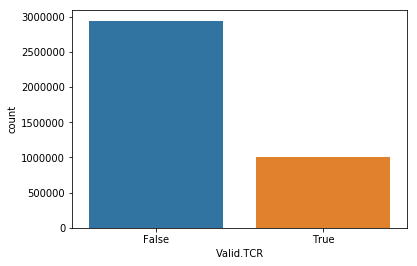

In [141]:
pass_bar = seaborn.categorical.countplot(x='Valid.TCR', data=tcr_df)
plt.savefig(fname="/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Pass_fail-bar.png",
            dpi=300, bbox_inches='tight')
plt.show()

In [142]:
# what proportion of alpha and beta chains fail, and in total?
tcr_df["TRA_Valid"].value_counts()/tcr_df.shape[0]

False    0.597777
True     0.402223
Name: TRA_Valid, dtype: float64

In [143]:
# what proportion of alpha and beta chains fail, and in total?
tcr_df["TRB_Valid"].value_counts()/tcr_df.shape[0]

True     0.631175
False    0.368825
Name: TRB_Valid, dtype: float64

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


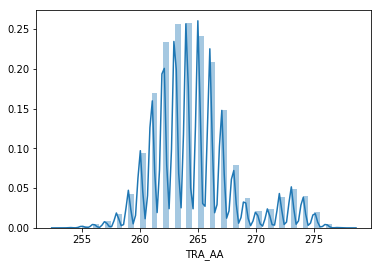

In [144]:
# TCRA entropy
seaborn.distplot(a=tcr_df.TRA_AA[tcr_df["Valid.TCR"]])
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TCRalpha_AAlen-histogram.png",
           dpi=300, bbox_inches='tight')

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


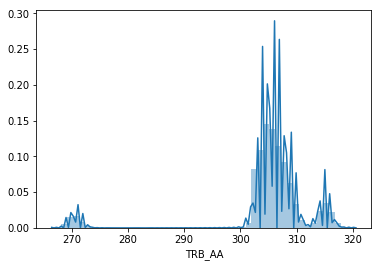

In [145]:
# TCRA entropy
seaborn.distplot(a=tcr_df.TRB_AA[tcr_df["Valid.TCR"]])
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TCRbeta_AAlen-histogram.png",
           dpi=300, bbox_inches='tight')

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


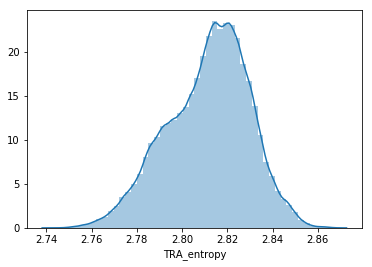

In [146]:
# TCRA entropy
seaborn.distplot(a=tcr_df.TRA_entropy[tcr_df["Valid.TCR"]])

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


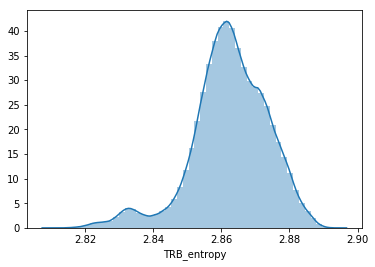

In [147]:
seaborn.distplot(a=tcr_df.TRB_entropy[tcr_df["Valid.TCR"]])

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


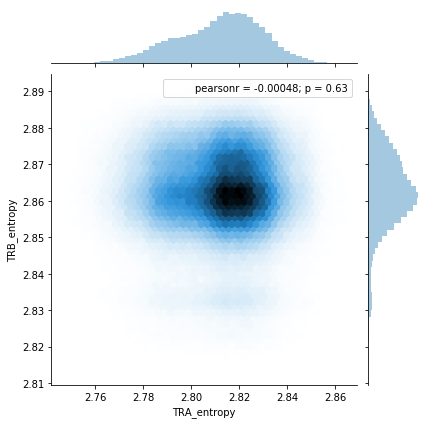

In [148]:
# joint distribution of entropies
seaborn.jointplot(x='TRA_entropy', y='TRB_entropy', data=tcr_df.loc[tcr_df["Valid.TCR"]], kind='hex')
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Entropy_joint_dist.png",
           dpi=300, bbox_inches='tight')

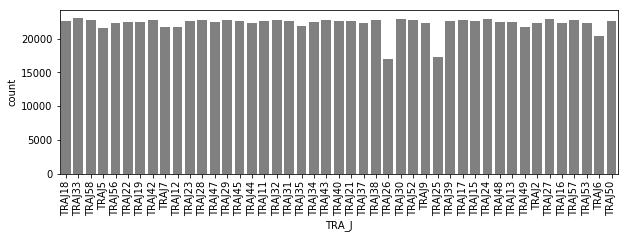

In [149]:
plt.figure(figsize=(10, 3))
axp = seaborn.categorical.countplot(x='TRA_J', data=tcr_df.loc[tcr_df["Valid.TCR"]], color='grey')
plt.xticks(rotation=90)
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TRA_Jregions-bar.png",
           dpi=300, bbox_inches='tight')

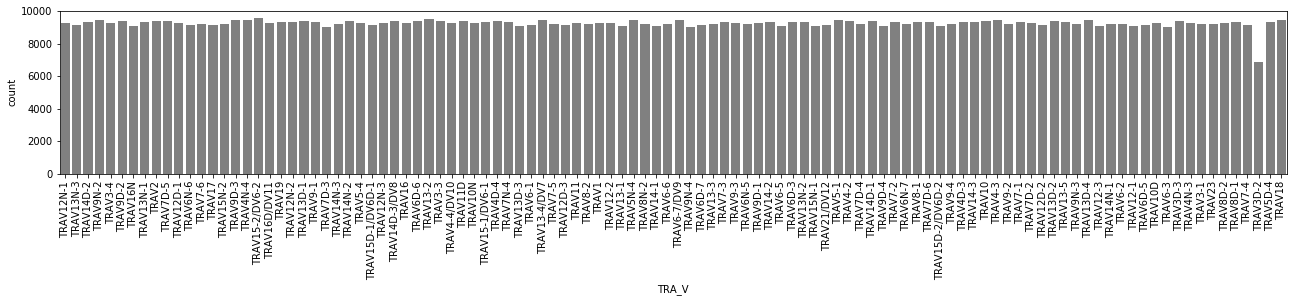

In [150]:
plt.figure(figsize=(22, 3))
seaborn.categorical.countplot(x='TRA_V', data=tcr_df.loc[tcr_df["Valid.TCR"]], color='grey')
plt.xticks(rotation=90)
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TRA_Vregions-bar.png",
           dpi=300, bbox_inches='tight')

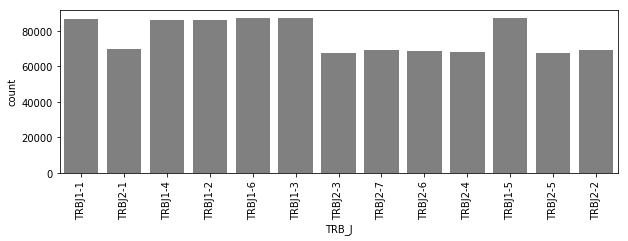

In [151]:
plt.figure(figsize=(10, 3))
seaborn.categorical.countplot(x='TRB_J', data=tcr_df.loc[tcr_df["Valid.TCR"]], color='grey')
plt.xticks(rotation=90)
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TRB_Jregions-bar.png",
           dpi=300, bbox_inches='tight')

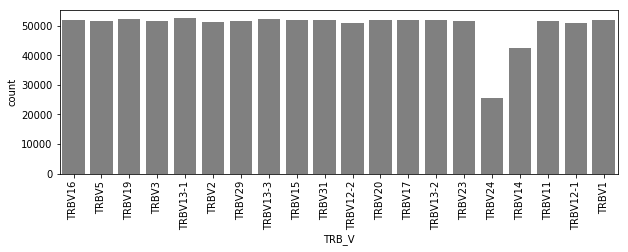

In [152]:
plt.figure(figsize=(10, 3))
seaborn.categorical.countplot(x='TRB_V', data=tcr_df.loc[tcr_df["Valid.TCR"]], color='grey')
plt.xticks(rotation=90)
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TRB_Vregions-bar.png",
           dpi=300, bbox_inches='tight')

In [153]:
# what are the combinations, Vbeta Vs Valpha, and the same for J regions?
v_cross = pd.crosstab(index=tcr_df.TRA_V[tcr_df["Valid.TCR"]], columns=tcr_df.TRB_V[tcr_df["Valid.TCR"]])
j_cross = pd.crosstab(index=tcr_df.TRA_J[tcr_df["Valid.TCR"]], columns=tcr_df.TRB_J[tcr_df["Valid.TCR"]])

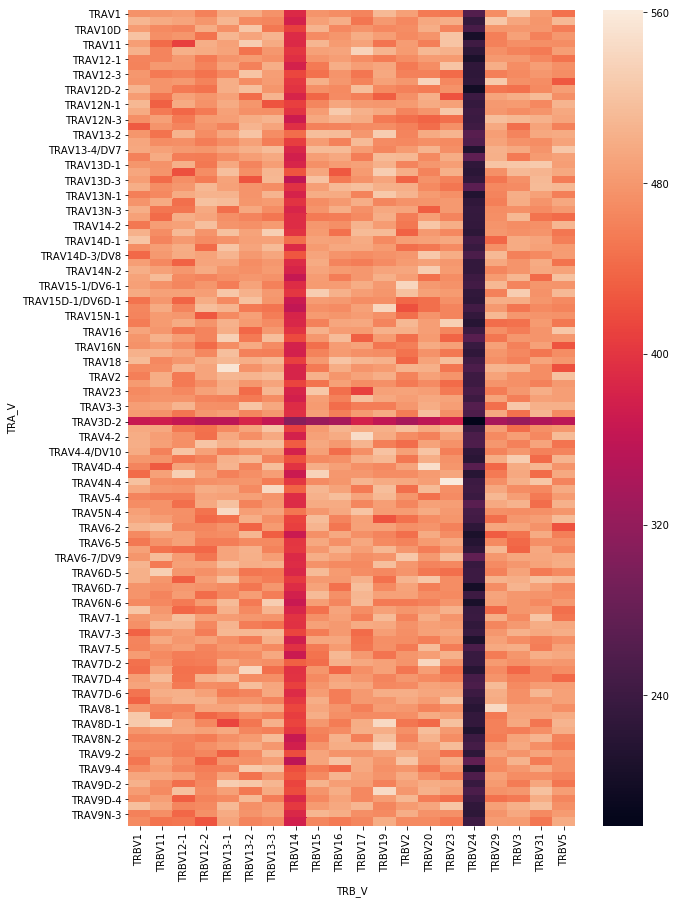

In [154]:
plt.figure(figsize=(10, 15))
v_hm = seaborn.heatmap(v_cross)
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Vregion-heatmap.png",
           dpi=300, bbox_inches='tight')

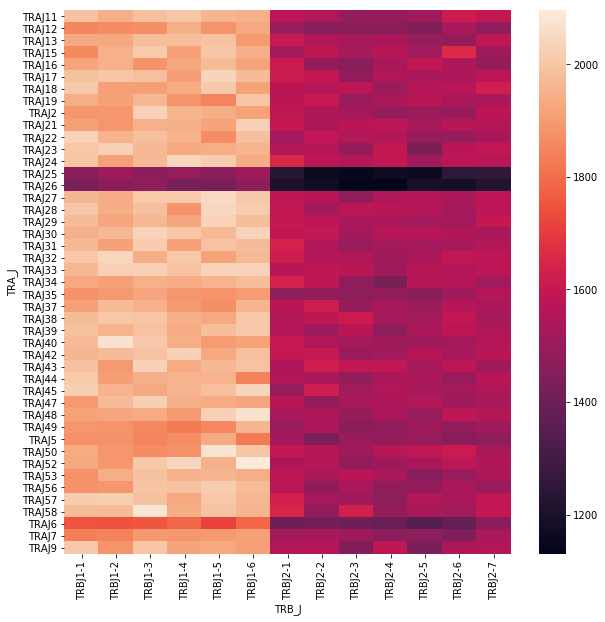

In [155]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(j_cross)
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Jregion-heatmap.png",
           dpi=300, bbox_inches='tight')
plt.show()

It seems that one of the major bottlenecks is to get a fully spliced mRNA transcript with all of the relevant V(D)J and constant regions.  Strictly speaking the TCR $\beta$ chain rearrangement should get a second chance.

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


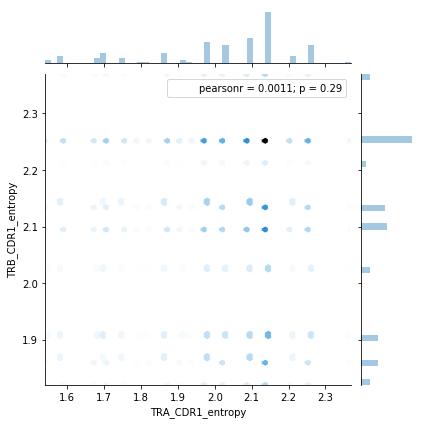

In [156]:
# joint distribution of entropies
seaborn.jointplot(x='TRA_CDR1_entropy', y='TRB_CDR1_entropy', 
                  data=tcr_df.loc[tcr_df["Valid.TCR"]], kind='hex')
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/CDR1_entropy_joint.png",
           dpi=300, bbox_inches='tight')
plt.show()

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


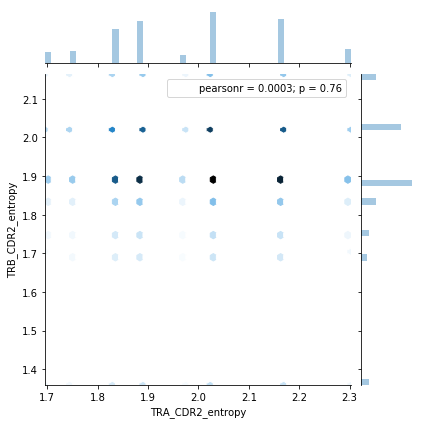

In [157]:
# joint distribution of entropies
seaborn.jointplot(x='TRA_CDR2_entropy', y='TRB_CDR2_entropy', 
                  data=tcr_df.loc[tcr_df["Valid.TCR"]], kind='hex')
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/CDR2_entropy_joint.png",
           dpi=300, bbox_inches='tight')
plt.show()

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


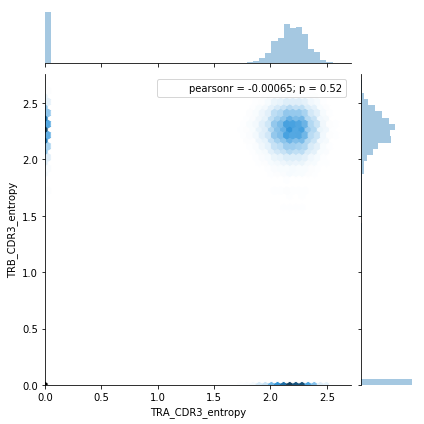

In [158]:
# joint distribution of entropies
seaborn.jointplot(x='TRA_CDR3_entropy', y='TRB_CDR3_entropy', 
                  data=tcr_df.loc[tcr_df["Valid.TCR"]], kind='hex')
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/CDR3_entropy_joint.png",
           dpi=300, bbox_inches='tight')
plt.show()

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


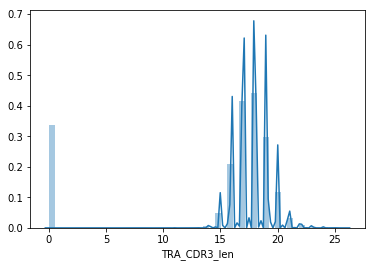

In [159]:
# TRA and TRB CDR3 length distributions
tcr_df.loc[tcr_df.loc[:, "TRA_CDR3"].isnull(), "TRA_CDR3"] = ""
tcr_df.loc[tcr_df.loc[:, "TRB_CDR3"].isnull(), "TRB_CDR3"] = ""
tcr_df["TRA_CDR3_len"] = tcr_df["TRA_CDR3"].apply(len)
tcr_df["TRB_CDR3_len"] = tcr_df["TRB_CDR3"].apply(len)

seaborn.distplot(a=tcr_df.TRA_CDR3_len[tcr_df["Valid.TCR"]])

/Users/morgan02/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


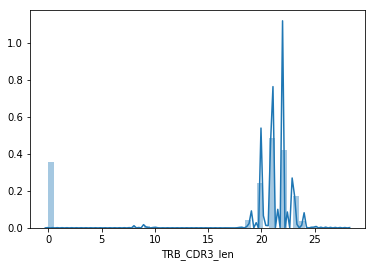

In [160]:
seaborn.distplot(a=tcr_df.TRB_CDR3_len[tcr_df["Valid.TCR"]])

In [161]:
tcr_df.loc[tcr_df["Valid.TCR"]].head()

,TRA_AA,TRA_CDR1,TRA_CDR1_entropy,TRA_CDR2,TRA_CDR2_entropy,TRA_CDR3,TRA_CDR3_entropy,TRA_J,TRA_Peptide,TRA_V,...,TRB_CDR3_entropy,TRB_J,TRB_Peptide,TRB_V,TRB_Valid,TRB_entropy,TRB_len,Valid.TCR,TRA_CDR3_len,TRB_CDR3_len
0,267,EGLVTVTEGLPV,1.748155,VQYLNEAPKL,2.163956,ALSERLDRGSALGRLHFGAG,2.042316,TRAJ18,MNRPVTCSVLVLLLLRRSNGDSVTQTEGLVTVTEGLPVLNCTYQTA...,TRAV12N-1,...,2.484367,TRBJ1-1,MAPRLLFCLVLCFLRAEPTNAGVIQTPRHKVTGKGQEATLWCEPIS...,TRBV16,True,2.874509,930,True,20,20
6,262,SPPASLVLQEGE,2.022809,YQRPGGRLVS,2.025326,,0.000000,TRAJ33,MKRLLCSLLGLLCTQVCWVKGQQVQQSPPASLVLQEGENAELQCTY...,TRAV13N-3,...,2.374111,TRBJ1-1,MSCRLLLYVSLCLVETALNTKITQSPRYLILGRANKSLECEQHLGH...,TRBV5,True,2.861059,930,True,0,22
9,275,RDQQQVRQSPQS,1.583258,STFDYFPWYR,2.025326,AASDGVQQGTGSKLSFGKG,2.128549,TRAJ58,MDKNLTASCLLLGHHLAGVSGQQQEKRDQQQVRQSPQSLTVWEGET...,TRAV14D-2,...,2.323397,TRBJ2-1,MNKWVFCWVTLCLLTVETTHGDGGIITQTPKFLIGQEGQKLTLKCQ...,TRBV19,True,2.869686,942,True,19,22
15,267,DARVTVSEGASL,2.138333,VQYPRQGLQL,1.834372,VLSALDRGSALGRLHFGAG,2.041345,TRAJ18,MLLALLPVLGIHFVLRDAQAQSVTQPDARVTVSEGASLQLRCKYSS...,TRAV9N-2,...,2.309633,TRBJ1-4,MDIWLLGWIIFSFLEAGHTGPKVLQIPSHQIIDGQVTLNCDPVSNH...,TRBV3,True,2.883230,933,True,19,21
24,266,QRPPHLSVPEGD,2.210254,WYKQEPGAGL,2.163956,AVSVAGTQVVGQLTFGRG,2.043192,TRAJ5,MKTVTGPLFLCFWLQLNCVSRGEQVEQRPPHLSVPEGDSAVIICTY...,TRAV3-4,...,2.045576,TRBJ1-2,MGSRLFLVLSLLCTKHEAAVTQSPRNKVTVTGGNVTLSCRQTNSHN...,TRBV13-1,True,2.859273,924,True,18,21


In [162]:
# # generate 1 million valid TCRs
# tcr_chains = generate_TCR(10**6, "/Users/morgan02/Dropbox/AgeingExperiment/TCR_FASTA")

# alpha_v = []
# beta_v = []

# alpha_len = []
# beta_len = []

# alpha_diversity = []
# beta_diversity = []

# alpha_j = []
# beta_j = []

# alpha_aa = []
# beta_aa = []

# alpha_pep = []
# beta_pep = []

# alpha_keep = []
# beta_keep = []

# alpha_cdr1 = []
# alpha_cdr2 = []
# alpha_cdr3 = []

# beta_cdr1 = []
# beta_cdr2 = []
# beta_cdr3 = []

# alpha_cdr1_diversity = []
# alpha_cdr2_diversity = []
# alpha_cdr3_diversity = []

# beta_cdr1_diversity = []
# beta_cdr2_diversity = []
# beta_cdr3_diversity = []

# for x in tcr_chains:
#     tcra = x['TCRA']
#     tcrb = x['TCRB']
    
#     alpha_v.append(tcra['V'])
#     alpha_j.append(tcra['J'])
#     alpha_len.append(len(tcra['RNA']))
#     # the entropy calculation should be for the CDR3 region or the V(D)J region only
#     # it should also be the translated AA sequence, not the nucleotide
#     alpha_rna_record = Fasta.FastaRecordPeptide(header='', sequence=tcra['AA'])
#     alpha_n_count = pd.Series(alpha_rna_record.counts)
#     alpha_diversity.append(stats.entropy(alpha_n_count/alpha_n_count.sum()))
#     alpha_aa.append(len(tcra['AA']))
#     alpha_pep.append(tcra['AA'])
#     alpha_keep.append(tcra["Valid.Chain"])
    
#     try:
#         # find the valid CDR regions if possible
#         # calculate the CDR entropies
#         alpha_cdr1_aa = get_CDR(tcra['AA'], 1)
#         alpha_aa_cdr1 = Fasta.FastaRecordPeptide(header='', sequence=alpha_cdr1_aa)
#         alpha_cdr1_count = pd.Series(alpha_aa_cdr1.counts)
#         alpha_cdr1_diversity.append(stats.entropy(alpha_cdr1_count/alpha_cdr1_count.sum()))
    
#         alpha_cdr2_aa = get_CDR(tcra['AA'], 2)
#         alpha_aa_cdr2 = Fasta.FastaRecordPeptide(header='', sequence=alpha_cdr2_aa)
#         alpha_cdr2_count = pd.Series(alpha_aa_cdr2.counts)
#         alpha_cdr2_diversity.append(stats.entropy(alpha_cdr2_count/alpha_cdr2_count.sum()))
    
#         try:
#             alpha_cdr3_aa = get_CDR(tcra['AA'], 3)
#             alpha_aa_cdr3 = Fasta.FastaRecordPeptide(header='', sequence=alpha_cdr3_aa)
#             alpha_cdr3_count = pd.Series(alpha_aa_cdr3.counts)
#             alpha_cdr3_diversity.append(stats.entropy(alpha_cdr3_count/alpha_cdr3_count.sum()))
#         except UnboundLocalError:
#             alpha_cdr3_aa = ""
#             alpha_cdr3_diversity.append(np.nan)
#     except TypeError:
#         alpha_cdr1_diversity.append(np.nan)
#         alpha_cdr2_diversity.append(np.nan)
#         alpha_cdr3_diversity.append(np.nan)
    
#     alpha_cdr1.append(alpha_cdr1_aa)
#     alpha_cdr2.append(alpha_cdr2_aa)
#     alpha_cdr3.append(alpha_cdr3_aa)    
    
#     beta_v.append(tcrb['V'])
#     beta_j.append(tcrb['J'])
#     beta_len.append(len(tcrb['RNA']))
#     beta_rna_record = Fasta.FastaRecordPeptide(header='', sequence=tcrb['AA'])
#     beta_n_count = pd.Series(beta_rna_record.counts)
#     beta_diversity.append(stats.entropy(beta_n_count/beta_n_count.sum()))
#     beta_aa.append(len(tcrb['AA']))
#     beta_pep.append(tcrb['AA'])
#     beta_keep.append(tcrb["Valid.Chain"])
    
#     try:
#         # calculate the CDR entropies
#         beta_cdr1_aa = get_CDR(tcrb['AA'], 1)
#         beta_aa_cdr1 = Fasta.FastaRecordPeptide(header='', sequence=beta_cdr1_aa)
#         beta_cdr1_count = pd.Series(beta_aa_cdr1.counts)
#         beta_cdr1_diversity.append(stats.entropy(beta_cdr1_count/beta_cdr1_count.sum()))
    
#         beta_cdr2_aa = get_CDR(tcrb['AA'], 2)
#         beta_aa_cdr2 = Fasta.FastaRecordPeptide(header='', sequence=beta_cdr2_aa)
#         beta_cdr2_count = pd.Series(beta_aa_cdr2.counts)
#         beta_cdr2_diversity.append(stats.entropy(beta_cdr2_count/beta_cdr2_count.sum()))
    
#         try:
#             beta_cdr3_aa = get_CDR(tcrb['AA'], 3)
#             beta_aa_cdr3 = Fasta.FastaRecordPeptide(header='', sequence=beta_cdr3_aa)
#             beta_cdr3_count = pd.Series(beta_aa_cdr3.counts)
#             beta_cdr3_diversity.append(stats.entropy(beta_cdr3_count/beta_cdr3_count.sum()))
#         except UnboundLocalError:
#             beta_cdr3_aa = ""
#             beta_cdr3_diversity.append(np.nan)
#     except TypeError:
#         beta_cdr1_diversity.append(np.nan)
#         beta_cdr2_diversity.append(np.nan)
#         beta_cdr3_diversity.append(np.nan)
    
#     beta_cdr1.append(beta_cdr1_aa)
#     beta_cdr2.append(beta_cdr2_aa)
#     beta_cdr3.append(beta_cdr3_aa)
    
# tcr_df = pd.DataFrame({"TRA_V": alpha_v, "TRA_J": alpha_j, "TRA_len": alpha_len, "TRA_entropy": alpha_diversity,
#                        "TRA_AA": alpha_aa, "TRA_Peptide": alpha_pep, "TRA_Valid": alpha_keep,
#                        "TRA_CDR1_entropy": alpha_cdr1_diversity, "TRA_CDR1": alpha_cdr1,
#                        "TRA_CDR2_entropy": alpha_cdr2_diversity, "TRA_CDR2": alpha_cdr2,
#                        "TRA_CDR3_entropy": alpha_cdr3_diversity, "TRA_CDR3": alpha_cdr3,                       
#                        "TRB_V": beta_v, "TRB_J": beta_j, "TRB_len": beta_len, "TRB_entropy": beta_diversity,
#                        "TRB_AA": beta_aa, "TRB_Peptide": beta_pep, "TRB_Valid": beta_keep,
#                        "TRB_CDR1_entropy": beta_cdr1_diversity, "TRB_CDR1": beta_cdr1,
#                        "TRB_CDR2_entropy": beta_cdr2_diversity, "TRB_CDR2": beta_cdr2,
#                        "TRB_CDR3_entropy": beta_cdr3_diversity, "TRB_CDR3": beta_cdr3})

# tcr_df["Valid.TCR"] = tcr_df.loc[:, ["TRA_Valid", "TRB_Valid"]].apply(lambda B: all(B), axis=1, reduce=True)